#  Bayesian and SDE Perspectives on DDPM and DDIM
Ref: https://www.youtube.com/watch?v=cS6JQpEY9cs  
Ref: https://spaces.ac.cn/   
Ref: Understanding Diffusion Models: A Unified Perspective

## Bayesian Perspective

### Forward process:

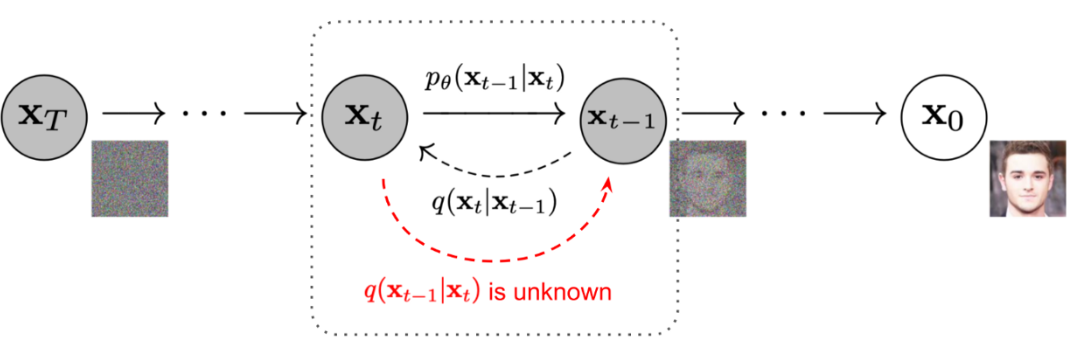
$$
q(x_{1:T}\vert x_{0}) := \prod_{t=1}^{T}q(x_{t}\vert x_{t-1}) :=\prod_{t=1}^{T}\mathcal{N}(x_{t};\sqrt{1-\beta_{t}} x_{t-1},\ \beta_{t}\bf I)
$$

To implement the above equation:

1. We have to define the total number of timesteps `T`
2. We have to generate $\beta_{t}$ using a schedule. We can use any schedule including but not limited to linear, quadratic, etc. The only thing that we need to ensure is that $\beta_{1} < \beta_{2}...$
3. Sample a new image at timestep `t` from a conditional Gaussian for which the paramters are $\mu_{t} = \sqrt{1-\beta_{t}} x_{t-1}$ and $\sigma_{t}^2 = \beta_{t}$
4. For the last point, we can use the property(eq. (13)) we studied in the conditional distribution section. Hence we can write this as:

$$x_{t} \sim (\mathcal{N}(\sqrt{1-\beta_{t}} x_{t-1},\ \beta_{t}) + \mathcal{N}(0, 1))$$

$$
\Rightarrow x_{t} = \sqrt{1-\beta_{t}} x_{t-1} + \sqrt{\beta_{t}}\epsilon \ \ ; \ \text{where} \ \epsilon \sim \mathcal{N}(0, 1) \tag{15}
$$

(Ref: https://github.com/AakashKumarNain/diffusion_models)

We know $q(x_1|x_0)$, $q(x_2|x_1)$, ... (Gaussian)  
If we know $x_0$, we know $x_T$ 
$$
q(x_{1:T}\vert x_{0})=\prod_{t=1}^{T}q(x_{t}\vert x_{t-1})
$$

### Reverse Process (Generation Problem): 


How to know **one** $x_0$ given $x_T$ (noise)?  
If we know $p(x_{T-1}|x_T)$, $p(x_{T-2}|x_{T-1})$, ..., 
we know $x_0$
$$
p(x_{T-1:0}\vert x_{T})=\prod_{t=T}^{1}p(x_{t-1}\vert x_{t})
$$


How to know $p(x_{t-1}|x_{t})$? It is similar to $q(x_{t-1}|x_{t})$  
How to know $q(x_{t-1}|x_{t})$? Bayesian may help?  
$$
q(x_{t-1}|x_{t})=\frac{q(x_{t}|x_{t-1})q(x_{t-1})}{q(x_{t})}
$$

**OOPS!** What is $q(x_{t})$ and $q(x_{t-1})$?  
We don't know, but we assume they are similar to 
$$
q(x_{t}|x_{0}) \text{  and  } q(x_{t-1}|x_{0})
$$
If the assumption is good enough, we have
$$
q(x_{t-1}|x_{t},x_0)=\frac{q(x_{t}|x_{t-1},x_0)q(x_{t-1}|x_0)}{q(x_{t}|x_0)}
$$

**BANG**
$$
q(x_{t-1}|x_{t},x_0) \text{  approximates  }   p(x_{t-1}|x_{t})
$$


**OOPS!** How to get $x_{0}$ in $q(x_{t-1}|x_{0})$ ?  
$$
\text{Guess  } x_{0} \text{  given  } x_{t} \text{ with a network}
$$

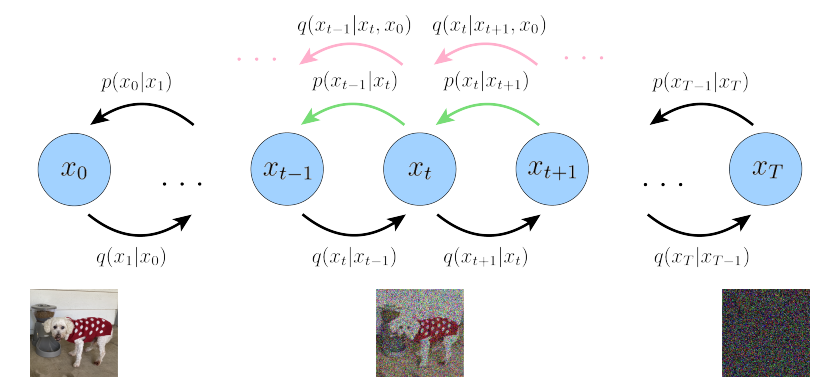

### DDIM

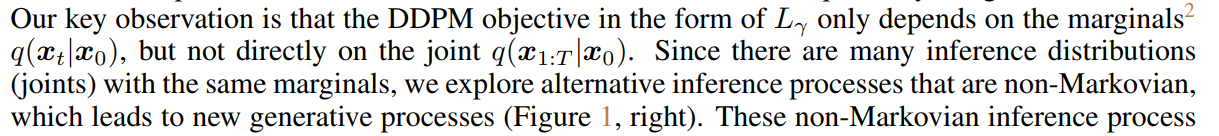
During training, we guess $x_{0}$ given $x_{t}$ with a network. Loss is a function of $x_{0}$ and $x_{t}$.  
$\Rightarrow$ Do we really need to know $q(x_{t}|x_{t-1})$?

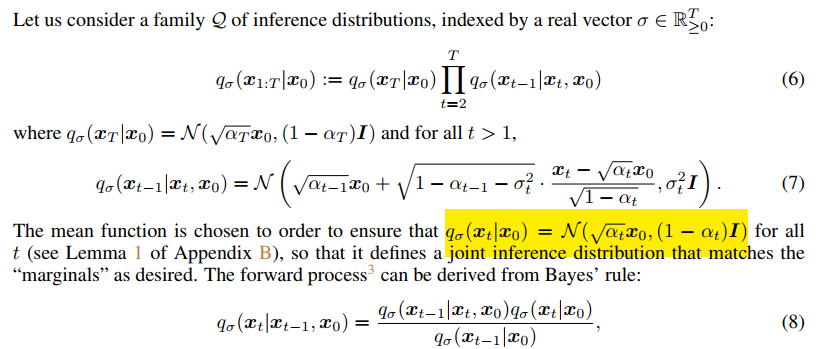

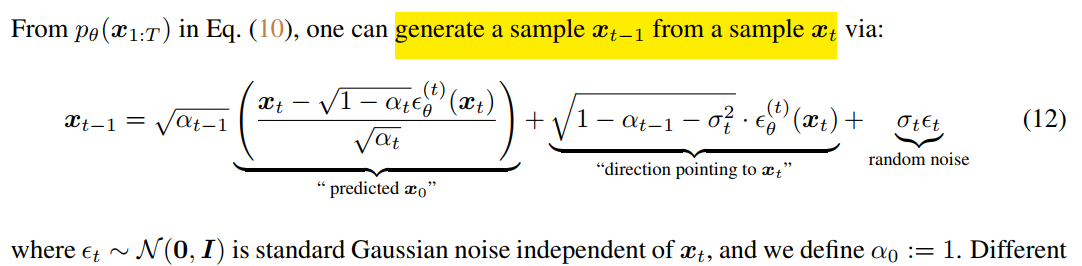

## Stochastic Differential Equation

$\beta_t$ is discrete for $t=1,2,3,4,...$. For continuous $\beta_t$, we get?

Let $\beta_t = \beta(t)\Delta t$
$$
\Rightarrow x_{t} = \sqrt{1-\beta(t)\Delta t} x_{t-1} + \sqrt{\beta(t)\Delta t}\mathcal{N}(0, 1)
$$

By Taylor expansion ($\Delta t \rightarrow 0$):
$$
\Rightarrow x_{t} \sim x_{t-1} - \frac{\beta(t)\Delta t}{2}x_{t-1} + \sqrt{\beta(t)\Delta t}\mathcal{N}(0, 1)
$$

$$
\Rightarrow dx_{t} = - \frac{\beta(t)}{2}x_{t}dt + \sqrt{\beta(t)}d\omega_t
$$

![img](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSxuuT7cr6cg8vtyuTV2p5ZlstiZYO6lq6iHQ&usqp=CAU)  
Ref: https://medium.com/from-the-diaries-of-john-henry/denoising-diffusion-based-generative-modeling-5daadc1d8ce2  
Image from: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSxuuT7cr6cg8vtyuTV2p5ZlstiZYO6lq6iHQ&usqp=CAU

(1, 10010)


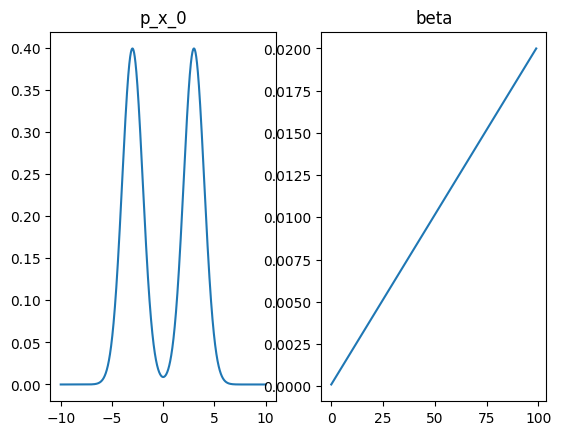

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def calculate_normal_pdf(x, mu=0, sigma=1):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * sigma**2))

np.random.seed(0)
weight = np.random.rand(10, 1)

'''
def generate_x0_pdf(x):
    y = 0
    for w in range(weight.shape[0]):    
        y += weight[w]*np.sin(w*x)
    y += weight.shape[0]
    return y
'''

def generate_x0_pdf(x):
    y = calculate_normal_pdf(x, -3, 1) + calculate_normal_pdf(x, 3, 1)
    return y

x_range = (-10, 10)
delta_x = 0.001
num_sample = 1000
num_x = int(x_range[1]-x_range[0]/delta_x)
p_x_0 = generate_x0_pdf(np.linspace(x_range[0],x_range[1],num_x))

# 1. Set x_0
p_x_0 = p_x_0.reshape(1, -1)

# 2. Define number of timesteps
timesteps = 100


# 3. Generate beta (variance schedule)
beta_start = 0.0001
beta_end = 0.02
t_start = 0
t_end = 1000
beta = np.linspace(beta_start, beta_end, num=timesteps, dtype=np.float32)

print(p_x_0.shape)
plt.subplot(121)
plt.plot(np.linspace(x_range[0],x_range[1],num_x), p_x_0.transpose())
plt.title('p_x_0')
plt.subplot(122)
plt.plot(beta)
plt.title('beta')
plt.show()

In [13]:
import tqdm
np.random.seed(0)

num_bin = int(num_x)
p_x_ode = [p_x_0/np.sum(p_x_0)]

for i in tqdm.tqdm(range(1, timesteps)):
    samples = np.random.choice(np.linspace(x_range[0],x_range[1],num_x),size=num_x*num_sample, p=p_x_ode[-1][0,:])
    samples = samples - beta[i]*(t_end/timesteps)/2 * samples
    hist, bins = np.histogram(samples, range=x_range, bins=num_bin, density=True)
    p_x_ode.append(hist.reshape(1,-1)/np.sum(hist))


100%|██████████| 99/99 [01:19<00:00,  1.24it/s]


$$
dx_{t} = - \frac{\beta(t)}{2}x_{t}dt
$$

([<matplotlib.axis.XTick at 0x1c0156a6ec0>,
 [Text(0.0, 0, '-10.0'), Text(5005.0, 0, '0.0'), Text(10010.0, 0, '10.0')])

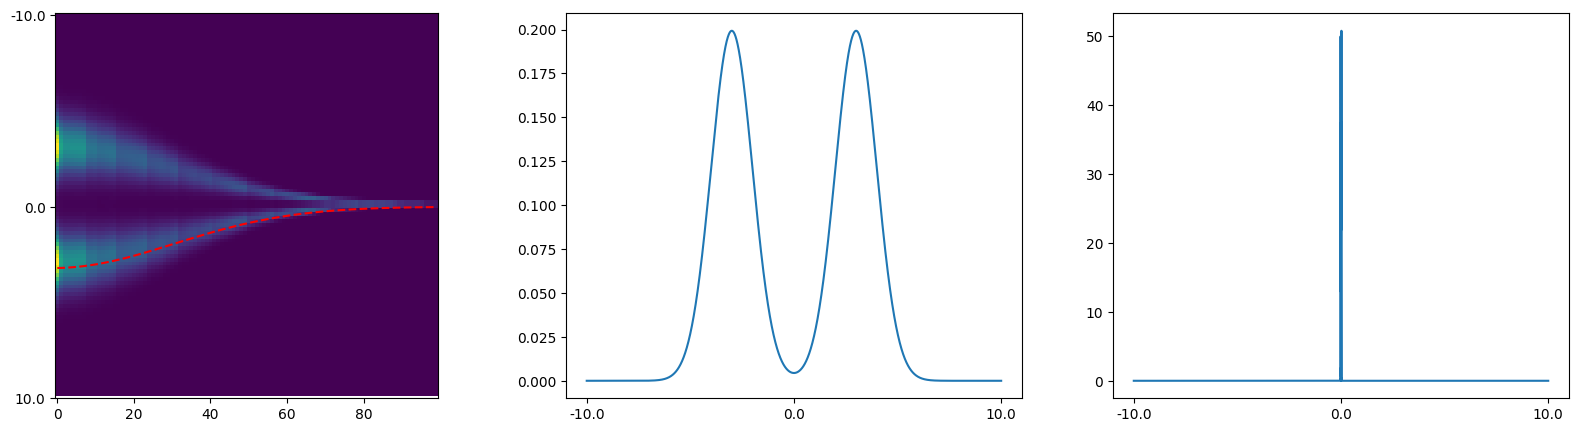

In [95]:
from PIL import Image

p_x_ode = np.vstack(p_x_ode)
formatted = (p_x_ode.transpose() / np.max(p_x_ode.transpose(), axis=0, keepdims=True) * 255).astype('uint8')
resized_img = Image.fromarray(formatted).resize((timesteps,timesteps))

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.imshow(resized_img)
curve_start = resized_img.size[1]/2-np.argmax(np.array(resized_img)[:,0])
plt.plot(np.arange(0,100), resized_img.size[0]/2 + np.cumprod(1-beta*(t_end/timesteps)/2)*curve_start, 'r--')
plt.yticks(np.linspace(0,resized_img.size[1],3), np.linspace(x_range[0],x_range[1],3))
plt.subplot(1,3,2)
plt.plot(p_x_ode[0,:]/delta_x/2)
plt.xticks(np.linspace(0,num_x,3), np.linspace(x_range[0],x_range[1],3))
plt.subplot(1,3,3)
plt.plot(p_x_ode[-1,:]/delta_x/2)
plt.xticks(np.linspace(0,num_x,3), np.linspace(x_range[0],x_range[1],3))

In [15]:
np.random.seed(0)

num_bin = int(num_x)
p_x_sde = [p_x_0/np.sum(p_x_0)]

for i in tqdm.tqdm(range(1, timesteps)):
    samples = np.random.choice(np.linspace(x_range[0],x_range[1],num_x),size=num_x*num_sample, p=p_x_sde[-1][0,:])
    samples = samples - beta[i]*(t_end/timesteps)/2 * samples + np.sqrt(beta[i]*(t_end/timesteps))*np.random.randn(*samples.shape)
    hist, bins = np.histogram(samples, range=x_range, bins=num_bin, density=True)
    p_x_sde.append(hist.reshape(1,-1)/np.sum(hist))


100%|██████████| 99/99 [01:48<00:00,  1.10s/it]


$$
dx_{t} = - \frac{\beta(t)}{2}x_{t}dt + \sqrt{\beta(t)}d\omega_t
$$

100%|██████████| 99/99 [00:00<00:00, 14145.33it/s]


([<matplotlib.axis.XTick at 0x1c0b872b2e0>,
 [Text(0.0, 0, '-10.0'), Text(5005.0, 0, '0.0'), Text(10010.0, 0, '10.0')])

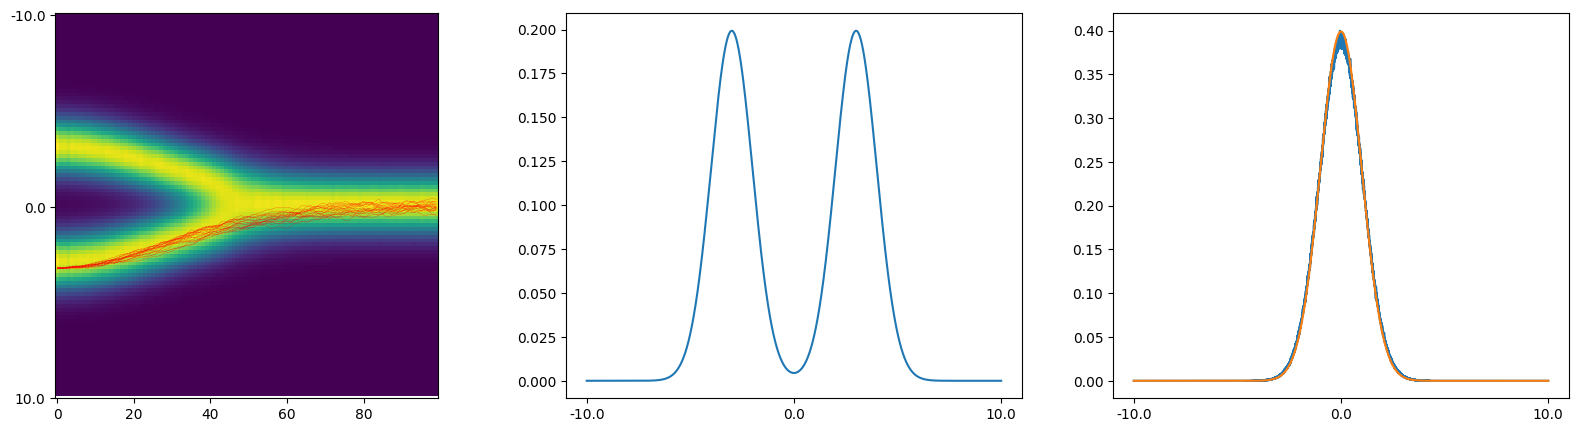

In [110]:
from PIL import Image
np.random.seed(0)
# plot curves
curve_start = resized_img.size[1]/2-np.argmax(np.array(resized_img)[:,0])
curve = np.zeros((20, timesteps))
curve[:,0] = curve_start
for i in tqdm.tqdm(range(1, timesteps)):
    for j in range(curve.shape[0]):
        curve[j, i] = (1-beta[i]*(t_end/timesteps)/2)*curve[j, i-1] + np.sqrt(beta[i]*(t_end/timesteps))*np.random.randn()

p_x_sde = np.vstack(p_x_sde)
formatted = (p_x_sde.transpose() / np.max(p_x_sde.transpose(), axis=0, keepdims=True) * 255).astype('uint8')
resized_img = Image.fromarray(formatted).resize((timesteps,timesteps))

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.imshow(resized_img)
for j in range(curve.shape[0]):
    plt.plot(resized_img.size[1]/2 + curve[j,:], 'r--', linewidth=0.2)
plt.yticks(np.linspace(0,resized_img.size[1],3), np.linspace(x_range[0],x_range[1],3))
plt.subplot(1,3,2)
plt.plot(p_x_sde[0,:]/delta_x/2)
plt.xticks(np.linspace(0,num_x,3), np.linspace(x_range[0],x_range[1],3))
plt.subplot(1,3,3)
plt.plot(p_x_sde[-1,:]/delta_x/2)
plt.plot(calculate_normal_pdf(np.linspace(x_range[0],x_range[1],num_x)))
plt.xticks(np.linspace(0,num_x,3), np.linspace(x_range[0],x_range[1],3))

![](https://yang-song.net/assets/img/score/perturb_vp.gif)  
Ref: https://yang-song.net/blog/2021/score/

### Generation
$$
\begin{align*}
q(x_{t-1}|x_{t}) &= \frac{q(x_{t}|x_{t-1})q(x_{t-1})}{q(x_{t})} \\
&= \mathcal{N}(x_{t};\sqrt{1-\beta_{t}} x_{t-1},\ \beta_{t}\mathbf{I})\exp(\log(q(x_{t-1}))-\log(q(x_{t})))
\end{align*}
$$

By Taylor expansion
$$
\log q(x_{t}) - \log q(x_{t-1}) \sim (x_{t}-x_{t-1})\nabla_{x_{t-1}}\log q(x_{t-1}) + ...
$$


#### Reverse Generative Diffusion SDE
$$
dx_{t} = - \frac{\beta(t)}{2}[x_{t} + 2\nabla_{x_t}\log q_t(x_t)]dt + \sqrt{\beta(t)}d\omega_t
$$
$\log q_t(x_t)$: the gradient of the log-likelihood of the data
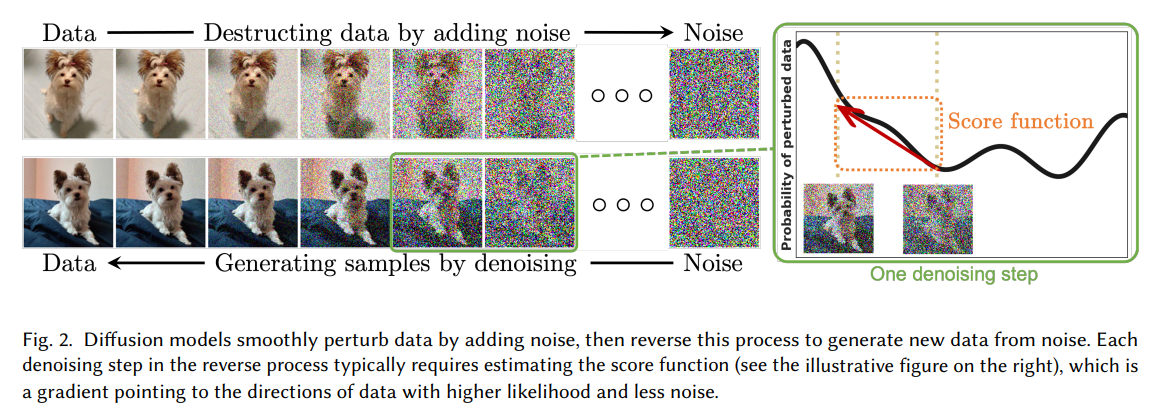

### How to Get $q_t(x_t)$

Intractable! But we can find $q_t(x_t|x_0)$  
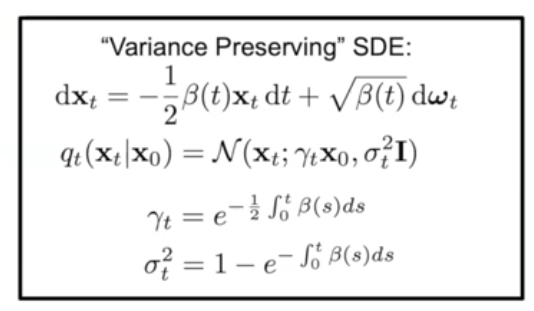
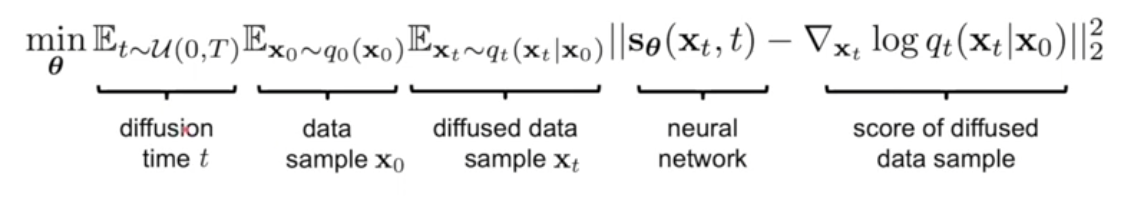

### DDIM
Remove $\sqrt{\beta(t)}d\omega_t$ from SDE to form a ODE:
$$
dx_{t} = - \frac{\beta(t)}{2}[x_{t} + 2\nabla_{x_t}\log q_t(x_t)]dt
$$
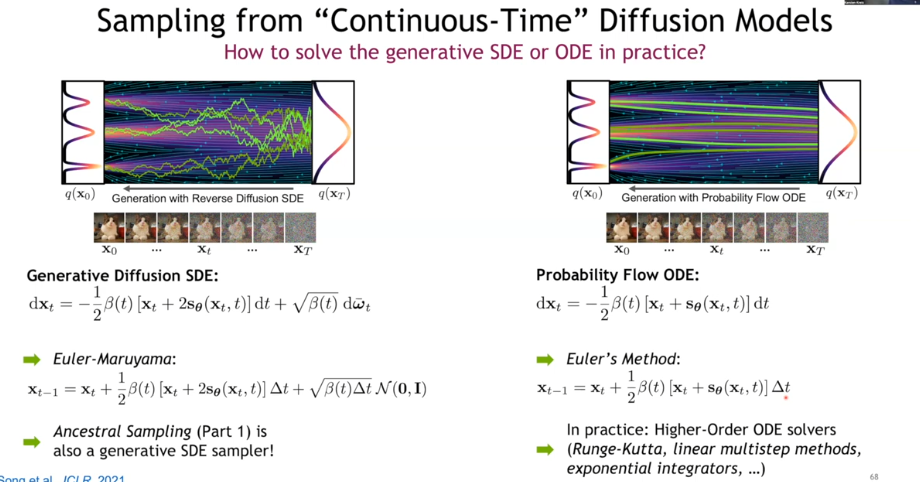

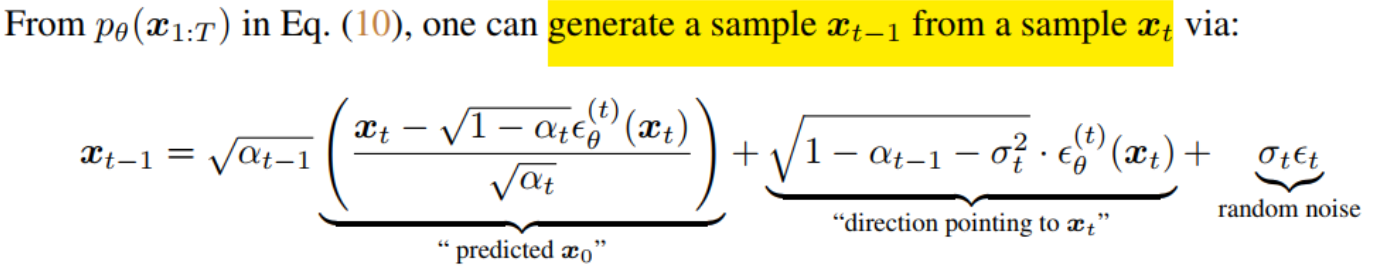